#Besoin Client n°3

## Import des bibliothèques

In [37]:
!pip install haversine
from google.colab import drive
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupShuffleSplit, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from haversine import haversine, Unit
from scipy.stats import randint, uniform
import plotly.graph_objects as go
import plotly.express as px
import pickle

## Import des données

In [38]:
drive.mount("/content/drive/")

data_clean = pd.read_csv('/content/drive/MyDrive/Projet_IA/data_clean.csv')

print(type(data_clean))
print(data_clean.head(5))


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
    id       MMSI         BaseDateTime       LAT       LON  SOG    COG  \
0   84  367387350  2023-05-29 00:00:01  25.76775 -80.14296  5.6  176.0   
1   91  367477280  2023-05-29 00:00:06  29.25456 -89.97235  0.0    0.0   
2  103  367037610  2023-05-29 00:00:06  29.88270 -89.95578  0.4  269.0   
3  118  368112000  2023-05-29 00:00:10  29.75368 -92.20613  7.1   51.4   
4  119  366954420  2023-05-29 00:00:10  27.77637 -82.63027  0.0    0.0   

   Heading        VesselName         IMO CallSign  VesselType  Status  Length  \
0      511      ISLAND QUEEN         NaN  WDE6981          60     NaN      20   
1        0              HERO  IMO8964147  WDH2114          60     0.0      47   
2      511           FRANK H         NaN  WDC5212          60     0.0      15   
3      511          ADRI LAB  IMO8739023  WDF2836          60 

## Tri des données

In [39]:
data_clean['BaseDateTime'] = pd.to_datetime(data_clean['BaseDateTime'])

data_clean = data_clean.sort_values(['MMSI', 'BaseDateTime']).reset_index(drop=True)


## Ajout des colonnes delta_t, delta_LAT, et delta_LON

In [52]:
data_clean['delta_t'] = data_clean.groupby('MMSI')['BaseDateTime'].diff().dt.total_seconds().shift(-1)

data_clean['delta_LAT'] = data_clean.groupby('MMSI')['LAT'].shift(-1)
data_clean['delta_LON'] = data_clean.groupby('MMSI')['LON'].shift(-1)

print(data_clean.head(5))

        id       MMSI        BaseDateTime       LAT       LON  SOG  COG  \
0  9067786  205776000 2023-05-25 00:07:27  25.95847 -97.37876  0.0  0.0   
1  9094320  205776000 2023-05-25 00:13:27  25.95846 -97.37880  0.0  0.0   
2  9113012  205776000 2023-05-25 00:16:27  25.95847 -97.37880  0.0  0.0   
3  9625845  205776000 2023-05-25 00:31:27  25.95848 -97.37879  0.0  0.0   
4  9261545  205776000 2023-05-25 00:34:27  25.95846 -97.37882  0.0  0.0   

   Heading VesselName         IMO  ... VesselType  Status  Length  Width  \
0        0    LA LUNA  IMO9846079  ...         70     5.0     200   32.0   
1        0    LA LUNA  IMO9846079  ...         70     5.0     200   32.0   
2        0    LA LUNA  IMO9846079  ...         70     5.0     200   32.0   
3        0    LA LUNA  IMO9846079  ...         70     5.0     200   32.0   
4        0    LA LUNA  IMO9846079  ...         70     5.0     200   32.0   

   Draft  Cargo  TransceiverClass delta_t  delta_LAT  delta_LON  
0   11.8   70.0           

## Sélection des données et mise en forme

In [41]:
X = data_clean[['LAT', 'LON', 'SOG', 'COG', 'VesselType', 'Heading', 'Length', 'Width', 'Draft', 'Cargo', 'delta_t']].copy()
y = data_clean[['delta_LAT', 'delta_LON']]

X['VesselType'] = X['VesselType'].apply(lambda x: 60 if 60 <= x <= 69 else x)
X['VesselType'] = X['VesselType'].apply(lambda x: 70 if 70 <= x <= 79 else x)
X['VesselType'] = X['VesselType'].apply(lambda x: 80 if 80 <= x <= 89 else x)

## Split des données en un jeu d'apprentissage et un jeu de test et suppression des NaN

In [42]:
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups=data_clean['MMSI']))

X_train = X.iloc[train_idx].copy()
X_test = X.iloc[test_idx].copy()
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]

nan_mask = y_train.isna().any(axis=1)
X_train = X_train[~nan_mask]
y_train = y_train[~nan_mask]

nan_mask = y_test.isna().any(axis=1)
X_test = X_test[~nan_mask]
y_test = y_test[~nan_mask]

##Mise en place de la pipeline et du preprocessing afin d'avoir un modèle optimal

In [43]:
categorical_features = ['VesselType', 'Cargo']
numerical_features = ['LAT', 'LON', 'SOG', 'COG', 'Heading', 'Length', 'Width', 'Draft', 'delta_t']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

## Apprentissage de notre modèle avec notre jeu de données d'apprentissage

In [44]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['LAT', 'LON', 'SOG', 'COG',
                                                   'Heading', 'Length', 'Width',
                                                   'Draft', 'delta_t']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['VesselType', 'Cargo'])])),
                ('regressor', LinearRegression())])

## Prédiction de notre jeu de données de test

In [45]:
y_pred_encoded = model_pipeline.predict(X_test)

##Test de notre modèle avec différentes métriques

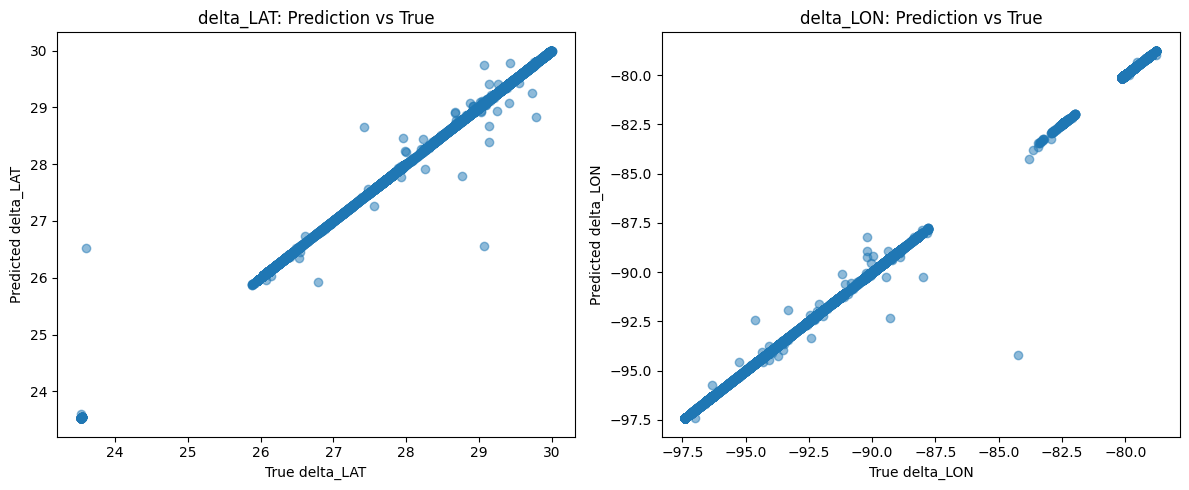

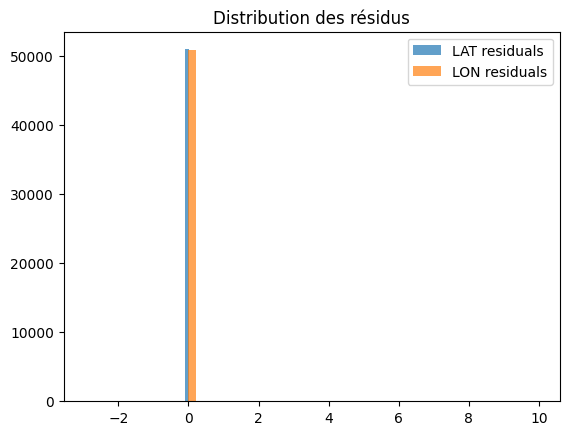

Results with One-Hot Encoding:
Mean Squared Error (LAT): 0.0004330087400974444
Mean Squared Error (LON): 0.0026311257217610552
MAE (LAT): 0.0015600924566344374
MAE (LON): 0.002714815422816516
RMSE (LAT): 0.020808862056764285
RMSE (LON): 0.05129449991725288
R-squared (LAT): 0.9996426500923368
R-squared (LON): 0.9998722425223285
Mean spatial error (meters): 346.41584810804926


In [46]:
mse_lat_encoded = mean_squared_error(y_test['delta_LAT'], y_pred_encoded[:, 0])
mse_lon_encoded = mean_squared_error(y_test['delta_LON'], y_pred_encoded[:, 1])

r2_lat_encoded = r2_score(y_test['delta_LAT'], y_pred_encoded[:, 0])
r2_lon_encoded = r2_score(y_test['delta_LON'], y_pred_encoded[:, 1])

mae_lat = mean_absolute_error(y_test['delta_LAT'], y_pred_encoded[:, 0])
mae_lon = mean_absolute_error(y_test['delta_LON'], y_pred_encoded[:, 1])

rmse_lat = np.sqrt(mse_lat_encoded)
rmse_lon = np.sqrt(mse_lon_encoded)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test['delta_LAT'], y_pred_encoded[:, 0], alpha=0.5)
plt.xlabel("True delta_LAT")
plt.ylabel("Predicted delta_LAT")
plt.title("delta_LAT: Prediction vs True")
plt.subplot(1, 2, 2)
plt.scatter(y_test['delta_LON'], y_pred_encoded[:, 1], alpha=0.5)
plt.xlabel("True delta_LON")
plt.ylabel("Predicted delta_LON")
plt.title("delta_LON: Prediction vs True")
plt.tight_layout()
plt.show()

residuals_lat = y_test['delta_LAT'] - y_pred_encoded[:, 0]
residuals_lon = y_test['delta_LON'] - y_pred_encoded[:, 1]
plt.hist(residuals_lat, bins=50, alpha=0.7, label='LAT residuals')
plt.hist(residuals_lon, bins=50, alpha=0.7, label='LON residuals')
plt.legend()
plt.title("Distribution des résidus")
plt.show()

pred_lat = y_pred_encoded[:, 0]
pred_lon = y_pred_encoded[:, 1]
pred_lon = (pred_lon + 180) % 360 - 180
pred_lat = (pred_lat + 180) % 360 - 180
pred_positions = np.vstack((pred_lat, pred_lon)).T
true_lat =y_test['delta_LAT'].to_numpy()
true_lon =y_test['delta_LON'].to_numpy()
true_positions = np.vstack((true_lat, true_lon)).T
errors_m = [haversine(tuple(true), tuple(pred), unit=Unit.METERS)
            for true, pred in zip(true_positions, pred_positions)]
mean_distance_error = np.mean(errors_m)

print("Results with One-Hot Encoding:")
print(f"Mean Squared Error (LAT): {mse_lat_encoded}")
print(f"Mean Squared Error (LON): {mse_lon_encoded}")
print(f"MAE (LAT): {mae_lat}")
print(f"MAE (LON): {mae_lon}")
print(f"RMSE (LAT): {rmse_lat}")
print(f"RMSE (LON): {rmse_lon}")
print(f"R-squared (LAT): {r2_lat_encoded}")
print(f"R-squared (LON): {r2_lon_encoded}")
print(f"Mean spatial error (meters): {mean_distance_error}")

## Enregistement de notre modèle au format pickle (pas faisable sous Google collab)

In [47]:
#Save in pickle

with open('model_3.pkl','wb') as f:
    pickle.dump(model_pipeline,f)


## Affichage des différentes cartes de validation

### Carte de comparaison entre valeurs réelles et valeurs prédites

In [48]:
df = pd.DataFrame({
    'true_lat': true_lat,
    'true_lon': true_lon,
    'pred_lat': pred_lat,
    'pred_lon': pred_lon,
    'error_m': errors_m
    })
threshold = 2 * mean_distance_error
df['correct'] = df['error_m'] <= threshold

pts_true_correct = df[df['correct']].assign(lat=df['true_lat'], lon=df['true_lon'], type='Bonne prédiction')
pts_true_incorrect = df[~df['correct']].assign(lat=df['true_lat'], lon=df['true_lon'], type='Position réelle (erreur)')
pts_pred_incorrect = df[~df['correct']].assign(lat=df['pred_lat'], lon=df['pred_lon'], type='Prédiction erronée')

plot_df = pd.concat([
    pts_true_incorrect[['lat','lon','type','error_m']],
    pts_pred_incorrect[['lat','lon','type','error_m']],
    pts_true_correct[['lat','lon','type','error_m']]
], ignore_index=True)

fig = px.scatter_map(
    plot_df,
    lat="lat", lon="lon",
    color="type",
    hover_data=["error_m"],
    map_style="open-street-map",
    height=700
)

fig.update_layout(
    title=f"Prédictions (marge = erreur moyenne = {threshold/2:.1f} m)",
    margin={"r":0,"t":40,"l":0,"b":0}
)

fig.write_html("prediction_map_val.html")
fig.show()

### Prédiction trajectoire superposée

In [49]:
mmsi_of_interest = 577278000
#mmsi_of_interest = 566646000
#mmsi_of_interest = 538005167

df_mmsi = data_clean[data_clean['MMSI'] == mmsi_of_interest].copy()

if df_mmsi.empty:
    print(f"Aucune donnée trouvée pour le MMSI {mmsi_of_interest}")
else:
    first_position = df_mmsi.iloc[0]
    current_lat = first_position['LAT']
    current_lon = first_position['LON']
    sog = first_position['SOG']
    cog = first_position['COG']
    heading = first_position['Heading']
    vessel_type = first_position['VesselType']
    length = first_position['Length']
    width = first_position['Width']
    draft = first_position['Draft']
    cargo = first_position['Cargo']
    estimated_delta_t = 300

    if 60 <= vessel_type <= 69:
        vessel_type = 60
    elif 70 <= vessel_type <= 79:
        vessel_type = 70
    elif 80 <= vessel_type <= 89:
        vessel_type = 80

    n_steps = len(df_mmsi) - 1
    future_positions = []

    for _ in range(n_steps):
        input_data = pd.DataFrame({
            'LAT': [current_lat],
            'LON': [current_lon],
            'SOG': [sog],
            'COG': [cog],
            'Heading': [heading],
            'VesselType': [vessel_type],
            'Length': [length],
            'Width': [width],
            'Draft': [draft],
            'Cargo': [cargo],
            'delta_t': [estimated_delta_t]
        })

        predicted_delta = model_pipeline.predict(input_data)[0]
        delta_lat, delta_lon = predicted_delta

        current_lat = delta_lat
        current_lon = delta_lon
        future_positions.append((current_lat, current_lon))

    if future_positions:
        future_lats, future_lons = zip(*future_positions)
    else:
        future_lats, future_lons = [], []


    fig = go.Figure()

    fig.add_trace(go.Scattermapbox(
        lat=df_mmsi['LAT'],
        lon=df_mmsi['LON'],
        mode='lines+markers',
        marker=go.scattermapbox.Marker(
            size=8,
            color='blue'
        ),
        name=f'Trajectoire historique (MMSI {mmsi_of_interest})'
    ))

    fig.add_trace(go.Scattermapbox(
        lat=[first_position['LAT']],
        lon=[first_position['LON']],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=15,
            color='green',
            symbol='star'
        ),
        name='Première position connue (point de départ de la prédiction)'
    ))

    fig.add_trace(go.Scattermapbox(
        lat=future_lats,
        lon=future_lons,
        mode='lines+markers',
        marker=go.scattermapbox.Marker(
            size=8,
            color='red'
        ),
        name='Trajectoire prédite en partant du début'
    ))

    fig.update_layout(
        mapbox_style="open-street-map",
        hovermode='closest',
        mapbox=dict(
            bearing=0,
            center=go.layout.mapbox.Center(
                lat=first_position['LAT'],
                lon=first_position['LON']
            ),
            pitch=0,
            zoom=10
        ),
        title=f'Comparaison Trajectoire historique et Trajectoire prédite (à partir du début) pour le MMSI {mmsi_of_interest}',
        margin={"r": 0, "t": 50, "l": 0, "b": 0}
    )
    fig.write_html("prediction_traj_superposed.html")
    fig.show()

### Affichage de la trajectoire du bateau NAVE PULSAR et prédiction de sa future trajecoire

#### Méthode : prédiction du point suivant à un delta temps puis point suivant prit comme point initial et on répète

In [50]:
#mmsi_of_interest = 248895000
mmsi_of_interest = 538005167

df_mmsi = data_clean[data_clean['MMSI'] == mmsi_of_interest].copy()

if df_mmsi.empty:
    print(f"Aucune donnée trouvée pour le MMSI {mmsi_of_interest}")
else:
    last_position = df_mmsi.iloc[-1]
    current_lat = last_position['LAT']
    current_lon = last_position['LON']
    sog = last_position['SOG']
    cog = last_position['COG']
    heading = last_position['Heading']
    vessel_type = last_position['VesselType']
    length = last_position['Length']
    width = last_position['Width']
    draft = last_position['Draft']
    cargo = last_position['Cargo']
    estimated_delta_t = 600

    if 60 <= vessel_type <= 69:
        vessel_type = 60
    elif 70 <= vessel_type <= 79:
        vessel_type = 70
    elif 80 <= vessel_type <= 89:
        vessel_type = 80

    n_steps = 2000
    future_positions = []

    for _ in range(n_steps):
        input_data = pd.DataFrame({
            'LAT': [current_lat],
            'LON': [current_lon],
            'SOG': [sog],
            'COG': [cog],
            'Heading': [heading],
            'VesselType': [vessel_type],
            'Length': [length],
            'Width': [width],
            'Draft': [draft],
            'Cargo': [cargo],
            'delta_t': [estimated_delta_t]
        })

        predicted_delta = model_pipeline.predict(input_data)[0]
        delta_lat, delta_lon = predicted_delta

        current_lat = delta_lat
        current_lon = delta_lon
        future_positions.append((current_lat, current_lon))

    future_lats, future_lons = zip(*future_positions)

    fig = go.Figure()

    fig.add_trace(go.Scattermapbox(
        lat=df_mmsi['LAT'],
        lon=df_mmsi['LON'],
        mode='lines+markers',
        marker=go.scattermapbox.Marker(
            size=8,
            color='blue'
        ),
        name=f'Trajectoire historique (MMSI {mmsi_of_interest})'
    ))

    fig.add_trace(go.Scattermapbox(
        lat=[last_position['LAT']],
        lon=[last_position['LON']],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=15,
            color='green',
            symbol='star'
        ),
        name='Dernière position connue'
    ))

    fig.add_trace(go.Scattermapbox(
        lat=future_lats,
        lon=future_lons,
        mode='lines+markers',
        marker=go.scattermapbox.Marker(
            size=8,
            color='red'
        ),
        name='Trajectoire future prédite'
    ))

    fig.update_layout(
        mapbox_style="open-street-map",
        hovermode='closest',
        mapbox=dict(
            bearing=0,
            center=go.layout.mapbox.Center(
                lat=last_position['LAT'],
                lon=last_position['LON']
            ),
            pitch=0,
            zoom=10
        ),
        title=f'Trajectoire historique et future prédite pour le MMSI {mmsi_of_interest}',
        margin={"r": 0, "t": 50, "l": 0, "b": 0}
    )
    fig.write_html("prediction_traj_suivant.html")
    fig.show()


#### Méthode : prédiction du point à un delta temps, puis à 2 fois le delta temps, puis 3 fois, etc

In [51]:
#mmsi_of_interest = 248895000
mmsi_of_interest = 538005167

df_mmsi = data_clean[data_clean['MMSI'] == mmsi_of_interest].copy()

if df_mmsi.empty:
    print(f"Aucune donnée trouvée pour le MMSI {mmsi_of_interest}")
else:
    last_position = df_mmsi.iloc[-1]
    base_lat = last_position['LAT']
    base_lon = last_position['LON']
    sog = last_position['SOG']
    cog = last_position['COG']
    heading = last_position['Heading']
    vessel_type = last_position['VesselType']
    length = last_position['Length']
    width = last_position['Width']
    draft = last_position['Draft']
    cargo = last_position['Cargo']
    base_delta_t = 600

    if 60 <= vessel_type <= 69:
        vessel_type = 60
    elif 70 <= vessel_type <= 79:
        vessel_type = 70
    elif 80 <= vessel_type <= 89:
        vessel_type = 80

    n_steps = 2000
    future_positions = []

    for step in range(1, n_steps + 1):
        current_delta_t = step * base_delta_t

        input_data = pd.DataFrame({
            'LAT': [base_lat],
            'LON': [base_lon],
            'SOG': [sog],
            'COG': [cog],
            'Heading': [heading],
            'VesselType': [vessel_type],
            'Length': [length],
            'Width': [width],
            'Draft': [draft],
            'Cargo': [cargo],
            'delta_t': [current_delta_t]
        })

        predicted_delta = model_pipeline.predict(input_data)[0]
        delta_lat, delta_lon = predicted_delta

        predicted_lat = delta_lat
        predicted_lon = delta_lon
        future_positions.append((predicted_lat, predicted_lon))

    future_lats, future_lons = zip(*future_positions)

    fig = go.Figure()

    fig.add_trace(go.Scattermapbox(
        lat=df_mmsi['LAT'],
        lon=df_mmsi['LON'],
        mode='lines+markers',
        marker=go.scattermapbox.Marker(
            size=8,
            color='blue'
        ),
        name=f'Trajectoire historique (MMSI {mmsi_of_interest})'
    ))

    fig.add_trace(go.Scattermapbox(
        lat=[base_lat],
        lon=[base_lon],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=15,
            color='green',
            symbol='star'
        ),
        name='Dernière position connue'
    ))

    fig.add_trace(go.Scattermapbox(
        lat=future_lats,
        lon=future_lons,
        mode='lines+markers',
        marker=go.scattermapbox.Marker(
            size=8,
            color='red'
        ),
        name='Trajectoire future prédite (fixe LAT/LON, delta_t croissant)'
    ))

    fig.update_layout(
        mapbox_style="open-street-map",
        hovermode='closest',
        mapbox=dict(
            bearing=0,
            center=go.layout.mapbox.Center(
                lat=base_lat,
                lon=base_lon
            ),
            pitch=0,
            zoom=10
        ),
        title=f'Trajectoire historique et future prédite pour le MMSI {mmsi_of_interest}',
        margin={"r": 0, "t": 50, "l": 0, "b": 0}
    )
    fig.write_html("prediction_traj_delta_evol.html")
    fig.show()
